### Imports & Utils

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.13-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

In [0]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
key = random.PRNGKey(0)

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

In [20]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

background_color = [0.85, 0.85, 0.9]

def format_plot(x, y):  
  plt.gca().set_axis_bgcolor(background_color)
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_schsam.kernel.schsam.135420007890.14b334fb3717c109/mount/server/dm_notebook.par/google3/third_party/py/matplotlib/__init__.py:1590: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



# Constant Energy Simulation


Here we demonstrate some code to run a simulation at constant energy. We start off by setting up some parameters of the simulation.

In [0]:
N = 5000
dimension = 2
box_size = 80.0
displacement, shift = space.periodic(box_size) 

Next we need to generate some random positions as well as particle sizes.

In [0]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [0]:
energy_fn = energy.soft_sphere_pairwise(
    displacement, species=species, sigma=sigma)
init, apply = simulate.nve(energy_fn, shift, 1e-2)
apply = jit(apply)
state = init(key, R, velocity_scale=0.0)

Now let's actually do the simulation. We'll keep track of potential energy and kinetic energy as the simulation progresses.

In [24]:
PE = []
KE = []

print_every = 10
old_time = time.clock()
print('Step\tKE\tPE\tTotal Energy\ttime/step')
print('----------------------------------------')

for i in range(200):
  state = lax.fori_loop(0, 10, lambda _, state: apply(state), state)
  
  PE += [energy_fn(state.position)]
  KE += [quantity.kinetic_energy(state.velocity)]
  
  if i % print_every == 0 and i > 0:
    new_time = time.clock()
    print('{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}'.format(
        i, KE[-1], PE[-1], KE[-1] + PE[-1], 
        (new_time - old_time) / print_every / 10.0))
    old_time = new_time

PE = np.array(PE)
KE = np.array(KE)
R = state.position

Step	KE	PE	Total Energy	time/step
----------------------------------------
0	10.36	750.28	760.638	0.11
10	485.13	275.49	760.617	0.97
20	460.09	300.53	760.627	0.98
30	457.84	302.79	760.630	0.99
40	446.56	314.07	760.631	0.97
50	446.48	314.16	760.633	0.97
60	454.23	306.41	760.633	0.97
70	453.27	307.37	760.635	0.99
80	449.58	311.05	760.637	1.04
90	457.68	302.95	760.637	1.01
100	457.36	303.28	760.641	1.02
110	456.49	304.15	760.642	0.98
120	469.86	290.78	760.643	0.97
130	458.74	301.90	760.646	1.00
140	465.92	294.73	760.646	0.99
150	458.24	302.41	760.649	1.06
160	460.55	300.10	760.652	1.00
170	463.81	296.85	760.653	0.96
180	460.34	300.31	760.654	0.99
190	452.50	308.15	760.655	0.97


Now, let's plot the energy as a function of time. We see that the initial potential energy goes down, the kinetic energy goes up, but the total energy stays constant.

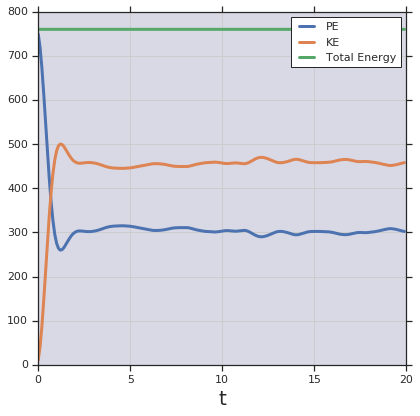

In [25]:
t = onp.arange(0, 2000, 10) * 1e-2
plt.plot(t, PE, label='PE', linewidth=3)
plt.plot(t, KE, label='KE', linewidth=3)
plt.plot(t, PE + KE, label='Total Energy', linewidth=3)
plt.legend()
format_plot('t', '')
finalize_plot()

Now let's plot the system.

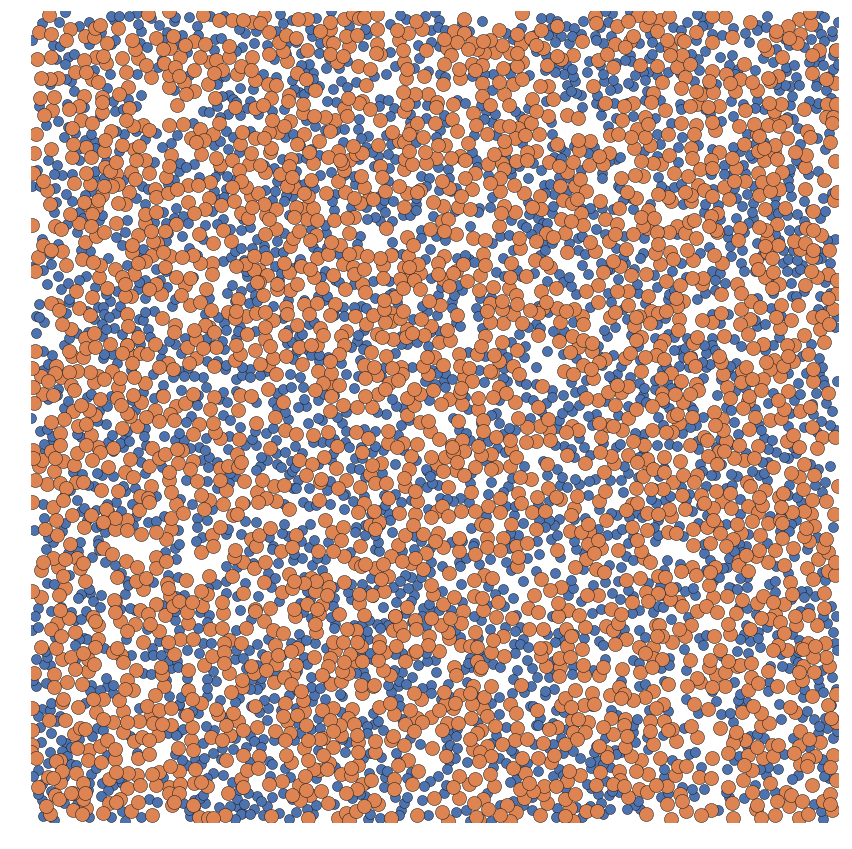

In [26]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))